# For every pair from scraped data from MAL, determine if an anime is better than the other

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Read data

In [5]:
drop_df = pd.read_csv('drop_ratio.csv', index_col=0)
score_df = pd.read_csv('scores.csv')

## Draw barplot of drop ratio

[Text(0.5, 0, 'Percentage')]

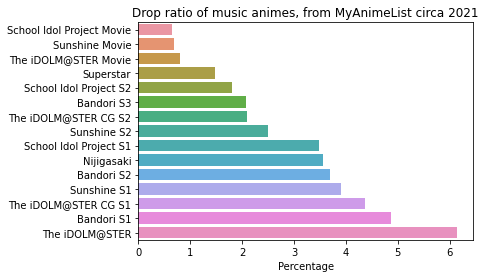

In [6]:
plt.title('Drop ratio of music animes, from MyAnimeList circa 2021')
ax = sns.barplot(data=drop_df, x='ratio', y=drop_df.index, orient='h')
ax.set(xlabel='Percentage')

## Define mathematical functions

### Student's t-test  
Used when 2 samples have similar variance ($\frac{1}{2} < \frac{s_1}{s_2} < 2$).

t statistic:
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/faf70034d0a3a686080b98b32f64f2cc62a5dbad)

Where 
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/451cd1fdd5cb308af96957c3cb28131035b07e97)

Degrees of freedom: $n_1 + n_2 - 1$.

In [ ]:
def unpack(sample1, sample2) -> tuple:
    '''
    Utility function to unpack std and count from 2 samples
    Returns: `s1, s2, n1, n2`
    '''
    return sample1['std'], sample2['std'], sample1['count'], sample2['count']

def student_sp(sample1, sample2) -> float:
    '''
    Student's t-test: Calculate the pooled standard deviation of 2 samples
    '''
    s1, s2, n1, n2 = unpack(sample1, sample2)

    return np.sqrt(
        ((n1 - 1) * (s1 ** 2) + (n2 - 1) * (s2 ** 2)) / (n1 + n2 - 2)
    )

def student_stat(sample1, sample2) -> float:
    '''
    Student's t-test: Calculate the `t` statistic of 2 independent samples with similar std.
    '''
    return (
        (sample1['mean'] - sample2['mean'])
        / (student_sp(sample1, sample2))
    )


### Welch's t-test  
Used when 2 samples have unequal variances ($s_1 > 2s_2$ or $s_2 > 2s_1$)

t statistic: 
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/eeecf40c622f1fa6b0fb9462c7c4b7030cbb47eb)

Where
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/5024dd38e905d60353a324af2a05058fdd4ac3e7)

Degrees of freedom: 
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/bf9929fa7098ff7e57a5c421c0fdcb3eea20435f)

In [ ]:
def welch_df(sample1, sample2) -> float:
    '''
    Welch's t-test: Calculate the Welch degree of freedom.
    '''
    s1, s2, n1, n2 = unpack(sample1, sample2)

    s_n = lambda i: (eval(f's{i}') ** 2) / eval(f'n{i}')
    return (
        ((s_n(1) + s_n(2)) ** 2) /
        ((s_n(1) ** 2) / (n1 - 1) + (s_n(2) ** 2) / (n2 - 1))
    )

def welch_sdelta(sample1, sample2) -> float:
    '''
    Welch's t-test: Calculate the unbiased estimator of 2 samples
    '''
    s1, s2, n1, n2 = unpack(sample1, sample2)
    return np.sqrt(
        s1**2/n1 + s2**2/n2
    )

def welch_stat(sample1, sample2) -> float: 
    '''
    Welch's t-test: Calculate the `t` statistic of 2 independent samples with unequal std.
    '''
    return (sample1['mean'] - sample2['mean']) / welch_sdelta(sample1, sample2)

### One-tailed hypothesis testing

$$
\begin{cases} 
H_0: \mu_1 \ge \mu_2 \\
H_1: \mu_1 < \mu2
\end{cases}
$$

or 

$$
\begin{cases} 
H_0: \mu_1 \le \mu_2 \\
H_1: \mu_1 > \mu2
\end{cases}
$$

Steps:
- Calculate t statistics. 
- Calculate p-value using Student's t-distribution $t_{df, T}$.
- If $p < \alpha$, reject $H_0$. 